In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1.1 Jeu de donnees

### 1. A quoi servent les ensembles d’apprentissage, de validation et de test ?\
<b>Ensemble d'apprentissage</b> : Cet ensemble est utilisé pour entraîner le modèle de réseau de neurones. Les données contenues dans cet ensemble sont utilisées pour ajuster les poids du réseau en fonction des caractéristiques des données et de leurs étiquettes. L'objectif est que le modèle apprenne à faire des prédictions en minimisant la fonction de coût.<br><br>
<b>Ensemble de validation</b> : Cet ensemble est utilisé pour évaluer les performances du modèle pendant son entraînement. Il est utilisé pour ajuster les hyperparamètres du modèle (comme la taille des couches, le taux d'apprentissage, etc.) et éviter le surajustement (overfitting). En observant les performances sur l'ensemble de validation, on peut sélectionner le modèle le plus performant.<br><br>
<b>Ensemble de test</b> : Une fois que le modèle a été entraîné et ses hyperparamètres ont été réglés, l'ensemble de test est utilisé pour évaluer les performances finales du modèle. Cela permet d'estimer comment le modèle généralise sur des données qu'il n'a pas vues pendant l'entraînement ou la validation

### 2. Quelle est l’influence du nombre N d’exemples ?
L'influence du nombre N d'exemples est significative dans plusieurs aspects de l'apprentissage supervisé :\
<b>Précision du modèle</b> : En général, plus le nombre d'exemples d'entraînement est grand, meilleure est la capacité du modèle à généraliser et à prédire avec précision sur de nouvelles données.<br><br>
<b>Risque de surajustement (overfitting)</b> : Avec un nombre limité d'exemples d'entraînement, il existe un risque plus élevé que le modèle s'adapte trop étroitement aux données d'entraînement, ce qui pourrait conduire à une faible généralisation sur de nouvelles données.

# 2.1 Forward et backward manuels

In [2]:
# Fonction pour initialiser les paramètres du réseau
def init_params(nx, nh, ny):
    params = {}
    params['W1'] = 0.3 * torch.randn(nh, nx)
    params['b1'] = torch.zeros((nh, 1))
    params['W2'] = 0.3 * torch.randn(ny, nh)
    params['b2'] = torch.zeros((ny, 1))
    return params

In [3]:
# Fonction forward pour calculer la sortie du réseau
def forward(params, X):
    Z1 = torch.mm(params['W1'], X) + params['b1']
    A1 = torch.tanh(Z1)
    Z2 = torch.mm(params['W2'], A1) + params['b2']
    Yhat = torch.exp(Z2) / torch.sum(torch.exp(Z2), dim=0)
    return {'X': X, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'Yhat': Yhat}

In [4]:
# Fonction de perte et précision
def loss_accuracy(Yhat, Y):
    m = Y.shape[1]
    loss = -torch.sum(Y * torch.log(Yhat)) / m
    _, indsY = torch.max(Y, 0)
    _, indsYhat = torch.max(Yhat, 0)
    acc = torch.sum(indsY == indsYhat).item() / m
    return loss, acc

In [5]:
# Fonction backward pour calculer les gradients
def backward(params, outputs, Y):
    m = Y.shape[1]
    dZ2 = outputs['Yhat'] - Y
    dW2 = (1 / m) * torch.mm(dZ2, outputs['A1'].t())
    db2 = (1 / m) * torch.sum(dZ2, dim=1, keepdim=True)
    dA1 = torch.mm(params['W2'].t(), dZ2)
    dZ1 = dA1 * (1 - torch.pow(outputs['A1'], 2))
    dW1 = (1 / m) * torch.mm(dZ1, outputs['X'].t())
    db1 = (1 / m) * torch.sum(dZ1, dim=1, keepdim=True)
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads

In [6]:
# Fonction pour la descente de gradient stochastique
def sgd(params, grads, eta):
    for param_name in params:
        params[param_name] -= eta * grads[f'd{param_name}']

In [7]:
# Génération de données de test
def generate_data(n_samples):
    np.random.seed(0)
    X = torch.tensor(np.random.randn(2, n_samples), dtype=torch.float)
    Y = (X[0, :] * X[1, :] > 0).type(torch.float)
    return X, Y

In [8]:
# Dans la fonction plot_data_with_grid
def plot_data_with_grid(X, Y, params, title):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
    h = .02  # Step size in the mesh
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()].T, dtype=torch.float)
    Z = forward(params, grid_data)['Yhat'].argmax(dim=0).numpy()
    Z = Z.reshape(xx.shape)
    plt.show()

In [9]:
# Algorithme global d'apprentissage
def train(X, Y, params, Nepochs, Nbatch, eta):
    for epoch in range(Nepochs):
        for batch_start in range(0, X.shape[1], Nbatch):
            Xbatch = X[:, batch_start:batch_start + Nbatch]
            Ybatch = Y[batch_start:batch_start + Nbatch].view(1, -1)
            
            # Forward Pass
            outputs = forward(params, Xbatch)
            
            # Loss and Accuracy
            loss, accuracy = loss_accuracy(outputs['Yhat'], Ybatch)
            
            # Backward Pass
            grads = backward(params, outputs, Ybatch)
            
            # Gradient Descent
            sgd(params, grads, eta)
            
            print(f'Epoch {epoch+1}, Batch {batch_start//Nbatch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}')
    
    plot_data_with_grid(X, Y, params, 'Decision Boundary')

Epoch 1, Batch 1, Loss: 0.5690028667449951, Accuracy: 0.5625
Epoch 1, Batch 2, Loss: 0.7835015058517456, Accuracy: 0.34375
Epoch 1, Batch 3, Loss: 0.7421190142631531, Accuracy: 0.4375
Epoch 1, Batch 4, Loss: 0.740050733089447, Accuracy: 0.71875
Epoch 1, Batch 5, Loss: 0.6094634532928467, Accuracy: 0.5625
Epoch 1, Batch 6, Loss: 0.8255789279937744, Accuracy: 0.46875
Epoch 1, Batch 7, Loss: 0.7384017109870911, Accuracy: 0.59375
Epoch 1, Batch 8, Loss: 0.9564467072486877, Accuracy: 0.28125
Epoch 1, Batch 9, Loss: 0.6091642379760742, Accuracy: 0.53125
Epoch 1, Batch 10, Loss: 0.7391039133071899, Accuracy: 0.46875
Epoch 1, Batch 11, Loss: 0.7811256051063538, Accuracy: 0.53125
Epoch 1, Batch 12, Loss: 0.5209074020385742, Accuracy: 0.4375
Epoch 1, Batch 13, Loss: 0.5205973982810974, Accuracy: 0.625
Epoch 2, Batch 1, Loss: 0.5660141706466675, Accuracy: 0.53125
Epoch 2, Batch 2, Loss: 0.7815251350402832, Accuracy: 0.3125
Epoch 2, Batch 3, Loss: 0.7398937940597534, Accuracy: 0.4375
Epoch 2, Batc

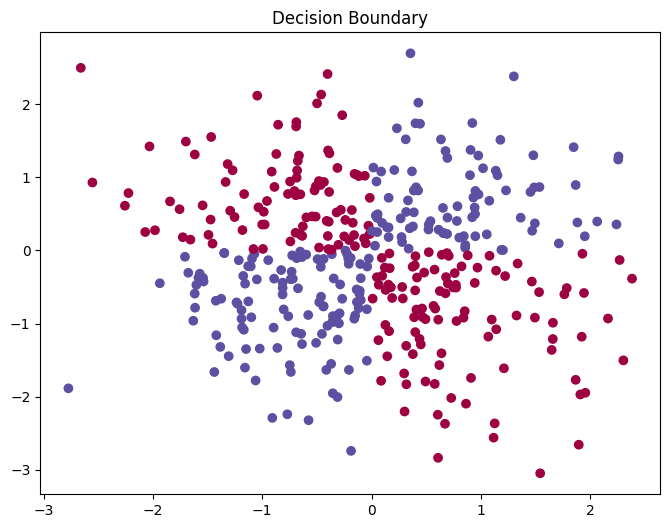

In [10]:
# Génération de données et entraînement
X, Y = generate_data(400)
params = init_params(2, 4, 2)
train(X, Y, params, Nepochs=100, Nbatch=32, eta=0.1)

# 2.2 Simplification du backward avec torch.autograd

In [11]:
# Fonction pour initialiser les paramètres du réseau
def init_params(nx, nh, ny):
    params = {}
    params['W1'] = 0.3 * torch.randn(nh, nx, requires_grad=True)
    params['b1'] = torch.zeros((nh, 1), requires_grad=True)
    params['W2'] = 0.3 * torch.randn(ny, nh, requires_grad=True)
    params['b2'] = torch.zeros((ny, 1), requires_grad=True)
    return params

In [12]:
# Fonction pour la descente de gradient stochastique
def sgd(params, eta):
    # Gradient Descent
    with torch.no_grad():
        for param_name, param in params.items():
            if param.grad is not None:  # Vérifie si le gradient n'est pas nul
                params[param_name].data -= eta * param.grad
                param.grad.zero_()

In [13]:
# Algorithme global d'apprentissage
def train(X, Y, params, Nepochs, Nbatch, eta):
    for epoch in range(Nepochs):
        for batch_start in range(0, X.shape[1], Nbatch):
            Xbatch = X[:, batch_start:batch_start + Nbatch]
            Ybatch = Y[batch_start:batch_start + Nbatch].view(1, -1)

            # Forward Pass
            outputs = forward(params, Xbatch)

            # Loss and Accuracy
            loss, accuracy = loss_accuracy(outputs['Yhat'], Ybatch)

            # Backward Pass
            loss.backward(retain_graph=True)  # Calcul des gradients par rapport à la perte

            # Gradient Descent
            sgd(params, eta)  # Mise à jour des poids avec les gradients

            # Réinitialiser les gradients à zéro pour la prochaine itération
            for param in params.values():
                if param.grad is not None:
                    param.grad.zero_()

            print(f'Epoch {epoch+1}, Batch {batch_start//Nbatch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}')

    plot_data_with_grid(X, Y, params, 'Decision Boundary')

C:\Users\sihah\AppData\Local\Temp\ipykernel_11708\758676134.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:491.)
  if param.grad is not None:  # Vérifie si le gradient n'est pas nul
C:\Users\sihah\AppData\Local\Temp\ipykernel_11708\3966945853.py:22: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, us

Epoch 1, Batch 1, Loss: 0.5836457014083862, Accuracy: 0.28125
Epoch 1, Batch 2, Loss: 0.8096291422843933, Accuracy: 0.71875
Epoch 1, Batch 3, Loss: 0.7635142803192139, Accuracy: 0.40625
Epoch 1, Batch 4, Loss: 0.7702702283859253, Accuracy: 0.375
Epoch 1, Batch 5, Loss: 0.6227011680603027, Accuracy: 0.53125
Epoch 1, Batch 6, Loss: 0.8513157367706299, Accuracy: 0.5625
Epoch 1, Batch 7, Loss: 0.7552298903465271, Accuracy: 0.53125
Epoch 1, Batch 8, Loss: 0.9805059432983398, Accuracy: 0.5625
Epoch 1, Batch 9, Loss: 0.6356291770935059, Accuracy: 0.53125
Epoch 1, Batch 10, Loss: 0.7580134868621826, Accuracy: 0.625
Epoch 1, Batch 11, Loss: 0.8058972954750061, Accuracy: 0.625
Epoch 1, Batch 12, Loss: 0.5351411700248718, Accuracy: 0.53125
Epoch 1, Batch 13, Loss: 0.5272281765937805, Accuracy: 0.5
Epoch 2, Batch 1, Loss: 0.5860387086868286, Accuracy: 0.28125
Epoch 2, Batch 2, Loss: 0.8084505796432495, Accuracy: 0.71875
Epoch 2, Batch 3, Loss: 0.7635205984115601, Accuracy: 0.40625
Epoch 2, Batch 4

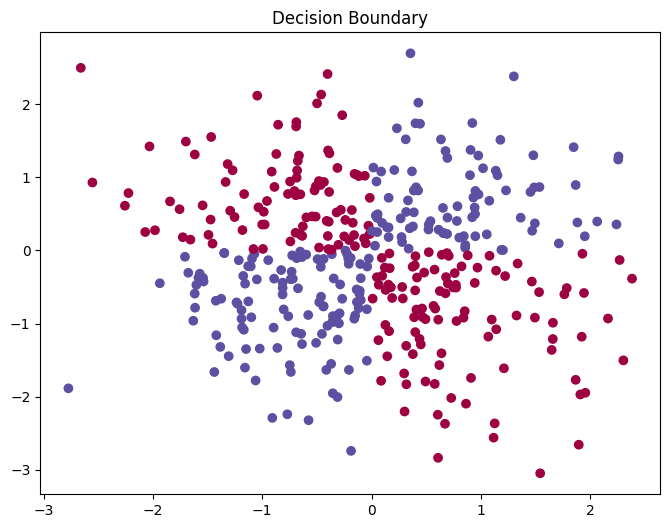

In [14]:
# Génération de données et entraînement
X, Y = generate_data(400)
params = init_params(2, 4, 2)
train(X, Y, params, Nepochs=100, Nbatch=32, eta=0.1)

# 2.3 Simplification du forward avec les couches torch.nn

Epoch 1, Batch 1, Loss: 0.7494529485702515
Epoch 1, Batch 2, Loss: 0.70586097240448
Epoch 1, Batch 3, Loss: 0.6925956606864929
Epoch 1, Batch 4, Loss: 0.693237841129303
Epoch 1, Batch 5, Loss: 0.6919528245925903
Epoch 1, Batch 6, Loss: 0.6879612803459167
Epoch 1, Batch 7, Loss: 0.6808819770812988
Epoch 1, Batch 8, Loss: 0.6971701979637146
Epoch 1, Batch 9, Loss: 0.6531944870948792
Epoch 1, Batch 10, Loss: 0.641034722328186
Epoch 1, Batch 11, Loss: 0.6090865135192871
Epoch 1, Batch 12, Loss: 0.620204746723175
Epoch 1, Batch 13, Loss: 0.6114486455917358
Epoch 2, Batch 1, Loss: 0.7119250297546387
Epoch 2, Batch 2, Loss: 0.58891761302948
Epoch 2, Batch 3, Loss: 0.6826896071434021
Epoch 2, Batch 4, Loss: 0.6188764572143555
Epoch 2, Batch 5, Loss: 0.569657564163208
Epoch 2, Batch 6, Loss: 0.5299955606460571
Epoch 2, Batch 7, Loss: 0.5612375140190125
Epoch 2, Batch 8, Loss: 0.5199126601219177
Epoch 2, Batch 9, Loss: 0.547545313835144
Epoch 2, Batch 10, Loss: 0.4733413755893707
Epoch 2, Batch 

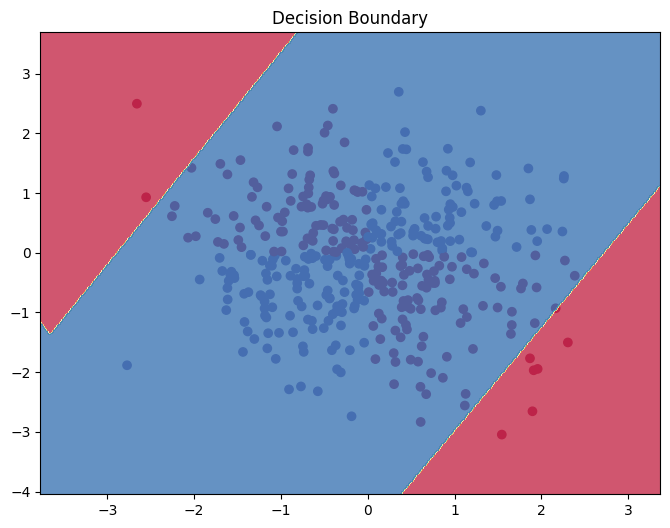

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to initialize the model architecture and loss
def init_model(nx, nh, ny):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.ReLU(),
        torch.nn.Linear(nh, ny)
    )
    loss = torch.nn.CrossEntropyLoss()
    return model, loss

# Function for the global training algorithm
def train(X, Y, model, loss_fn, Nepochs, Nbatch, eta):
    for epoch in range(Nepochs):
        for batch_start in range(0, X.shape[1], Nbatch):
            Xbatch = X[:, batch_start:batch_start + Nbatch].t()
            Ybatch = Y[batch_start:batch_start + Nbatch].long()

            # Forward Pass
            Yhat = model(Xbatch)

            # Loss Calculation
            L = loss_fn(Yhat, Ybatch)

            # Backward Pass
            loss_fn.zero_grad()  # Clear gradients before backward pass
            L.backward()  # Calculate gradients

            # Gradient Descent
            with torch.no_grad():
                for param in model.parameters():
                    param -= eta * param.grad

            print(f'Epoch {epoch + 1}, Batch {batch_start // Nbatch + 1}, Loss: {L.item()}')

# Data generation function
def generate_data(n_samples):
    np.random.seed(0)
    X = torch.tensor(np.random.randn(2, n_samples), dtype=torch.float)
    Y = (X[0, :] * X[1, :] > 0).type(torch.long)
    return X, Y

# Plotting function
def plot_data_with_grid(X, Y, model, title):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
    h = .02  # Step size in the mesh
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()].T, dtype=torch.float)
    Z = model(grid_data.T).argmax(dim=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.show()

# Data generation and training
X, Y = generate_data(400)
model, loss_fn = init_model(2, 4, 2)
train(X, Y, model, loss_fn, Nepochs=100, Nbatch=32, eta=0.1)
plot_data_with_grid(X, Y, model, 'Decision Boundary')

# 2.4 Simplification de SGD avec torch.optim

Epoch 1, Batch 1, Loss: 0.7700258493423462
Epoch 1, Batch 2, Loss: 0.688805341720581
Epoch 1, Batch 3, Loss: 0.7090715169906616
Epoch 1, Batch 4, Loss: 0.7051836252212524
Epoch 1, Batch 5, Loss: 0.7218013405799866
Epoch 1, Batch 6, Loss: 0.6876137256622314
Epoch 1, Batch 7, Loss: 0.6865788698196411
Epoch 1, Batch 8, Loss: 0.6556998491287231
Epoch 1, Batch 9, Loss: 0.7114521861076355
Epoch 1, Batch 10, Loss: 0.680053174495697
Epoch 1, Batch 11, Loss: 0.6723039746284485
Epoch 1, Batch 12, Loss: 0.7135578393936157
Epoch 1, Batch 13, Loss: 0.6932501196861267
Epoch 2, Batch 1, Loss: 0.6976578235626221
Epoch 2, Batch 2, Loss: 0.6860023140907288
Epoch 2, Batch 3, Loss: 0.6733545660972595
Epoch 2, Batch 4, Loss: 0.6665595173835754
Epoch 2, Batch 5, Loss: 0.6742123365402222
Epoch 2, Batch 6, Loss: 0.6716235280036926
Epoch 2, Batch 7, Loss: 0.6610264182090759
Epoch 2, Batch 8, Loss: 0.6620974540710449
Epoch 2, Batch 9, Loss: 0.6754866242408752
Epoch 2, Batch 10, Loss: 0.6683016419410706
Epoch 2,

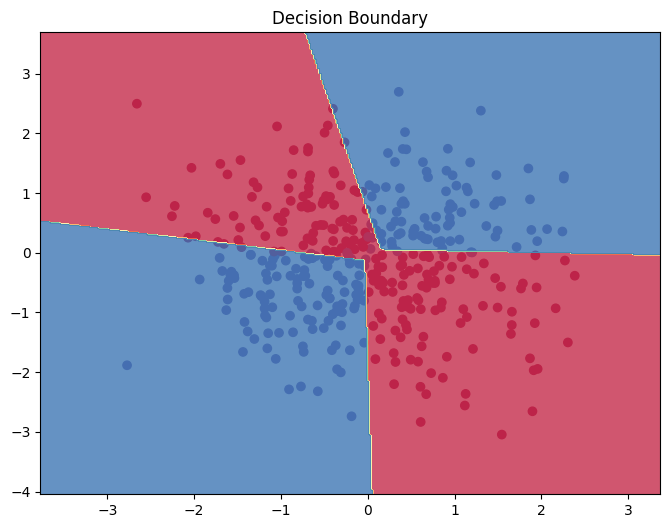

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to initialize the model architecture, loss, and optimizer
def init_model(nx, nh, ny, eta):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.ReLU(),
        torch.nn.Linear(nh, ny)
    )
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)
    return model, loss, optimizer

# Function for the global training algorithm
def train(X, Y, model, loss_fn, optimizer, Nepochs, Nbatch, eta):
    for epoch in range(Nepochs):
        for batch_start in range(0, X.shape[1], Nbatch):
            Xbatch = X[:, batch_start:batch_start + Nbatch].t()
            Ybatch = Y[batch_start:batch_start + Nbatch].long()

            # Forward Pass
            Yhat = model(Xbatch)

            # Loss Calculation
            L = loss_fn(Yhat, Ybatch)

            # Backward Pass
            optimizer.zero_grad()  # Clear gradients
            L.backward()  # Calculate gradients

            # Gradient Descent
            optimizer.step()  # Update weights

            print(f'Epoch {epoch + 1}, Batch {batch_start // Nbatch + 1}, Loss: {L.item()}')

# Data generation function
def generate_data(n_samples):
    np.random.seed(0)
    X = torch.tensor(np.random.randn(2, n_samples), dtype=torch.float)
    Y = (X[0, :] * X[1, :] > 0).type(torch.long)
    return X, Y

# Plotting function
def plot_data_with_grid(X, Y, model, title):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
    h = .02  # Step size in the mesh
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()].T, dtype=torch.float)
    Z = model(grid_data.t()).argmax(dim=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.show()

# Data generation and training
X, Y = generate_data(400)
model, loss_fn, optimizer = init_model(2, 4, 2, 0.1)
train(X, Y, model, loss_fn, optimizer, Nepochs=100, Nbatch=32, eta=0.1)
plot_data_with_grid(X, Y, model, 'Decision Boundary')

# 2.5 Application a MNIST

In [17]:
import torch
from torchvision import datasets, transforms

class MNISTData:
    def __init__(self, batch_size):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True
        )

        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=False, download=True, transform=transform),
            batch_size=batch_size, shuffle=True
        )

# Usage of MNISTData in the training process
mnist_data = MNISTData(batch_size=64)  # Set your desired batch size
train_loader = mnist_data.train_loader

# Initialize the model, loss, optimizer
model, loss_fn, optimizer = init_model(28 * 28, 128, 10, 0.01)  # Input size for MNIST is 28x28
num_epochs = 10  # Number of epochs for training
log_interval = 100
# Training loop
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.shape[0], -1)  # Flatten the input data
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item()}')

# Continue with test set evaluation, plotting, and further analysis if needed


100%|██████████| 9912422/9912422 [01:00<00:00, 162876.30it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 786483.06it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:06<00:00, 270687.48it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 2229957.72it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.3583760261535645
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.4736945629119873
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.9357675313949585
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.6840454936027527
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.6295397877693176
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.5428138971328735
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.40526434779167175
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.46060359477996826
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.36096835136413574
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.36336225271224976
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.39039498567581177
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.33163854479789734
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.649401843547821
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.43028566241264343
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.5751461982727051
Train Epoch: 1 [32000/60000 (53%)]	

In [18]:
# Test set evaluation
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in mnist_data.test_loader:
        data = data.view(data.shape[0], -1)  # Flatten the input data
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

test_loss /= len(mnist_data.test_loader.dataset)
accuracy = 100. * correct / len(mnist_data.test_loader.dataset)

print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# You can add further analysis or visualizations here



Test set: Average loss: 0.0029, Accuracy: 94.60%
